# SIR model for Coronavirus 2019- Case China

# Import library

In [1]:
import os
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import pandas as pd
import commonFunction as cf

# SIR model
* S(t) is the number of susceptible individuals. 
\begin{equation*}
\frac{dS(t)}{dt} = -\beta \frac{S(t)I(t)}{N}
\end{equation*}
* I(t) is the number of infected individuals. 
\begin{equation*}
\frac{dI(t)}{dt} = \beta \frac{S(t)I(t)}{N}-\gamma I(t)
\end{equation*}
* R(t) is the number of recovered individuals
\begin{equation*}
\frac{dR(t)}{dt} = \gamma I(t)
\end{equation*}

In [2]:
# ODEs
def SIR_model(y, t, N, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I / N
    dI_dt = beta * S * I / N - gamma * I
    dR_dt = gamma * I
    return dS_dt, dI_dt, dR_dt

# Read Real data- update on 3/6/2020

In [3]:
base_path = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = cf.readData(base_path, 'time_series_19-covid-Confirmed.csv','Confirmed')
df_deaths = cf.readData(base_path, 'time_series_19-covid-Deaths.csv','Deaths')
df_recovered = cf.readData(base_path, 'time_series_19-covid-Recovered.csv','Recovered')
df_confirmed = df_confirmed[df_confirmed['Country/Region']=='Mainland China']
df_deaths = df_deaths[df_deaths['Country/Region']=='Mainland China']
df_recovered = df_recovered[df_recovered['Country/Region']=='Mainland China']
df = df_confirmed.append(df_deaths)
df = df.append(df_recovered)
df = df[['Date', 'Province/State', 'Country/Region', 'Confirmed','Deaths','Recovered']]
df[['Confirmed','Deaths','Recovered']] = df[['Confirmed','Deaths','Recovered']].fillna(0)
df_trend = df.groupby(['Date']).sum()
df_trend['Infected'] = df_trend['Confirmed']-df_trend['Deaths']-df_trend['Recovered']

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [4]:
df_trend.tail()

,Confirmed,Deaths,Recovered,Infected
Date,,,,
2020-03-03,80151.0,2945.0,47404.0,29802.0
2020-03-04,80271.0,2981.0,49955.0,27335.0
2020-03-05,80422.0,3013.0,52240.0,25169.0
2020-03-06,80573.0,3042.0,53888.0,23643.0
2020-03-07,80652.0,3070.0,55478.0,22104.0


In [5]:
df_trend = df_trend.reset_index()
start_date = df_trend['Date'][0].strftime("%Y-%m-%d")
end_date = df_trend['Date'][len(df_trend)-1].strftime("%Y-%m-%d")

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


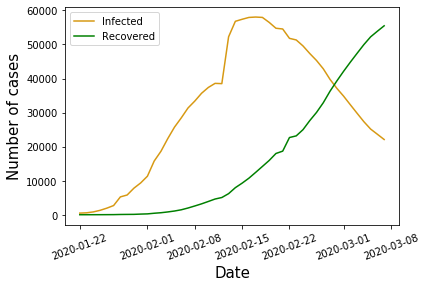

In [6]:
start = pd.Timestamp(start_date)
end = pd.Timestamp(end_date)
t = np.linspace(start.value, end.value, len(df_trend))
t = pd.to_datetime(t)
plt.plot(t, 'Infected', data=df_trend, color='#D79913')
plt.plot(t, 'Recovered', data=df_trend, color='green')
plt.ylabel('Number of cases', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xticks(rotation=20)
plt.legend()
plt.show()

# Parameter and initial condition
* $\beta$ is the infectious rate
* $\gamma$ is the recovery rate

In [7]:
# Total population of China
# Fractions will affect the max number of population infected.
N = 1437570976
N = N*0.000056 

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = df_trend['Infected'][0], df_trend['Recovered'][0]
S0 = N - I0 - R0

# Hyper parameter beta and gamma
# Beta will move the trend left or right
# Gamma will shrink or expand the trend
beta, gamma = 0.37, 0.03
y0 = S0, I0, R0

# Build model

In [8]:
y0 = S0, I0, R0
days=np.linspace(0,len(df_trend)-1,len(df_trend))
ret = scipy.integrate.odeint(SIR_model, y0, days, args=(N, beta, gamma))
S, I, R = ret.T

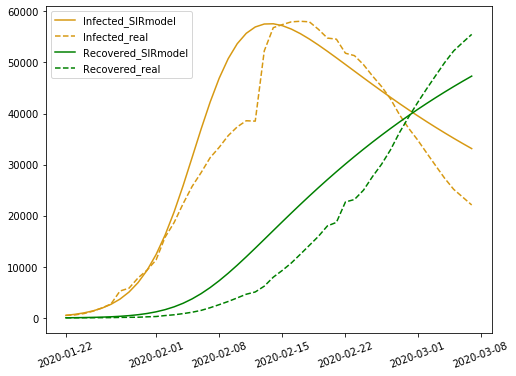

In [9]:
# Plot for infected and Recovered
plt.figure(figsize=[8,6])
plt.plot(t, I, color='#D79913', label='Infected_SIRmodel')
plt.plot(t, 'Infected', data=df_trend, linestyle='dashed',color='#D79913',label='Infected_real')
plt.plot(t, R, color='g', label='Recovered_SIRmodel')
plt.plot(t, 'Recovered', data=df_trend, linestyle='dashed',color='g',label='Recovered_real')
plt.xticks(rotation=20)
plt.legend()
plt.show()

# Prediction

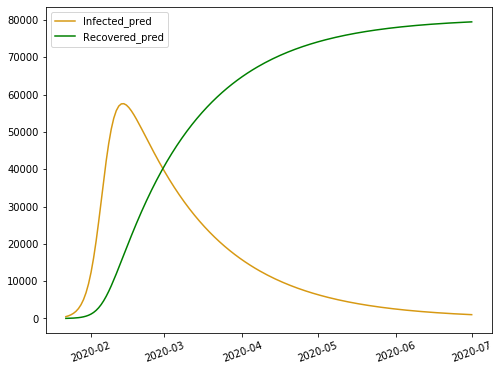

In [10]:
start = pd.Timestamp('2020-01-22')
end = pd.Timestamp('2020-7-1')
t = np.linspace(start.value, end.value, 162)
t = pd.to_datetime(t)
days = np.linspace(0,161,162)
prediction = scipy.integrate.odeint(SIR_model, y0, days, args=(N, beta, gamma))
S_p, I_p, R_p = prediction.T

plt.figure(figsize=[8,6])
plt.plot(t, I_p, color='#D79913', label='Infected_pred')
plt.plot(t, R_p, color='g', label='Recovered_pred')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [11]:
data = np.array([list(S_p),list(I_p),list(R_p)])
df = pd.DataFrame({"Date":t,"S":list(S_p), "I":list(I_p),"R":list(R_p)})
df = df.round(0)
df.tail()

,Date,S,I,R
157,2020-06-27,0.0,1154.0,79350.0
158,2020-06-28,0.0,1119.0,79384.0
159,2020-06-29,0.0,1086.0,79417.0
160,2020-06-30,0.0,1054.0,79449.0
161,2020-07-01,0.0,1023.0,79480.0
